In [1]:
import numpy as np
from numpy.random import multivariate_normal
import pandas as pd
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
%matplotlib inline

from advectionGPdatasets.gaussianbump import GaussianBump

In [2]:
gb = GaussianBump()

In [3]:
X, Y, sourceGT, concTrain, boundary, m = gb.X, gb.Y, gb.source, gb.conc, gb.boundary, gb.m

In [4]:
#gb.plot()

In [11]:
np.random.seed(42)

N_feat = 1000 #Number of features used to infer the source
k = EQ(2, 0.5)
res = [60,30,30]
noiseSD = 0.05
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(0.4,0.4)

from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as MFModel
mInfer = MFModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=0.01)
mInfer.computeModelRegressors(Nparticles=20)
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

Nsamps = 1
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)
print("Actual number of features: %d" % k.N_feat)

Initialising particles...
Computing SS...
Inverting SS...
Computing meanZ
Done
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
Actual number of features: 1000


In [12]:
scaleby = [5,1,1]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]].T #20x10x10
concmean,concvar,conc = mInfer.computeConcentration(Zs=Zs,Nparticles=10,interpolateSource=True,coords=coords)

Initialising particles...
(30, 30, 12, 3)
(10, 30, 30, 12, 3)
Particle shape:
(10, 30, 30, 12, 3)
Diffusing particles...


In [14]:
#====Non-negative sampling===

from advectionGP.constraints import NonNegConstraint
from advectionGP.kernels import meshgridndim
#points we enforce the constraint at
Xnonneg = meshgridndim(mInfer.boundary,10,True)
nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=5,burnin=2,jitter=0.02,verbose=True)
#Zs_nonneg = nnc.sample(Nsamps)
nnc.tm.findstartpoint_full()

Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Finding Start Point


array([ 1.89995334e-01,  3.70415699e-02,  2.01384697e-02,  6.26663951e-01,
        3.69262629e+00, -6.26690197e-03,  3.41405116e+00, -1.65354220e-01,
       -8.14615977e-02, -8.60435953e-01,  3.59864619e-01, -1.96963309e-01,
       -3.83198001e+00, -2.76498327e-01, -5.31127366e-01,  3.38979594e-01,
        9.95867275e-03,  8.06283710e-03, -5.48705190e-02, -6.77083017e-01,
       -3.34837182e-01,  1.89222906e+00, -4.43504223e-01,  1.13852036e-01,
        6.19283138e+00, -2.06163075e-01, -9.43496681e-01,  2.03203314e-01,
       -4.56142488e-01, -3.30556265e-01, -1.58547801e-01, -2.73992016e-01,
       -4.75546572e-01, -2.54651096e-01, -5.24425912e-03,  3.30383857e-01,
        1.05713133e+00, -4.25871198e+00, -1.78953053e+00,  5.50180238e-01,
       -3.08183852e-01,  5.40188400e-01, -2.12996045e-01, -4.90456326e-02,
        8.38375348e-01, -4.50482373e-01, -5.99459475e-01,  8.72371825e-01,
       -1.51902379e-01,  2.41208474e-01,  2.41982256e-01,  3.73698031e-01,
        4.02392135e-01, -

In [15]:
from qpsolvers import solve_qp


ImportError: no QP solver found, you can install some by running:

	pip install qpsolvers[open_source_solvers]


In [ ]:
def findstartpoint_full(self,margin=1e-4):
    """Finds the start point by minimising the distance from the mean, while constrained by
    the planes (plus the margin).
    """
    if self.verbose: print("Finding Start Point")
    fun = lambda x: np.sum((x-self.mean)**2)
    cons = ({'type': 'ineq', 'fun': lambda x:  self.Phi@x-margin})
    res = minimize(fun, self.mean, method='SLSQP',
                   constraints=cons)
    if not np.all(self.Phi @ res.x > 0):
        raise NoValidStartPointFoundError("No valid start location has been found. Specify one, using 'initx' and/or check the domain contains non-zero space (i.e. that the truncations don't completely occlude the space.")
    return res.x

In [ ]:
nnc.tm.findstartpoint_full()

In [8]:
sources_nonneg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs_nonneg])
sourcemean_nonneg = np.mean(sources_nonneg,0)
sourcevar_nonneg = np.var(sources_nonneg,0)

cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...


In [9]:
concmean_nonneg,concvar_nonneg,conc_nonneg = mInfer.computeConcentration(Zs=Zs_nonneg,Nsamps=10,Nparticles=10,interpolateSource=True,coords=coords)

Initialising particles...
Particle shape:
(10, 12, 30, 30, 3)
Diffusing particles...


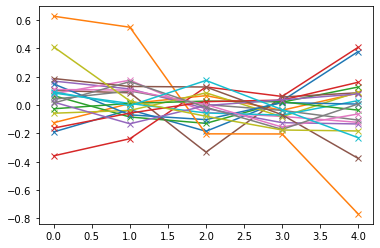

In [10]:
plt.plot(Zs_nonneg[:,::10]-np.mean(Zs_nonneg[:,::10],0),'x-');

In [11]:
np.unique(mInfer.getGridCoord(Xnonneg)[:,1])

array([ 0,  3,  6,  9, 13, 16, 19, 23, 26, 29])

In [12]:
np.unique(mInfer.getGridCoord(Xnonneg)[:,0])

array([ 0,  6, 13, 19, 26, 33, 39, 46, 53, 59])

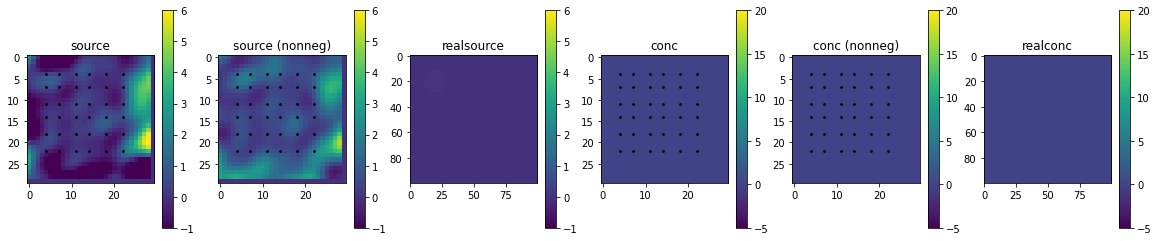

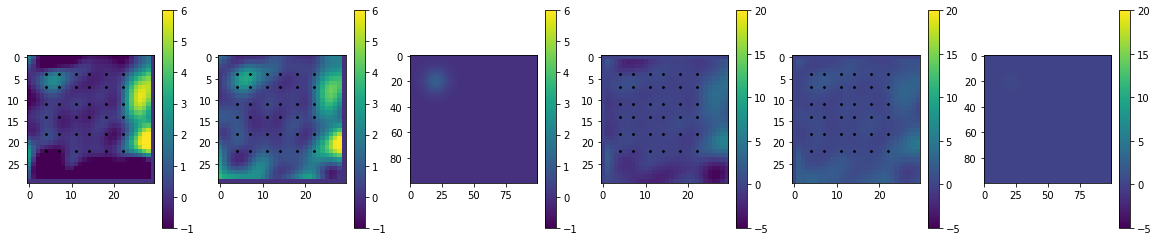

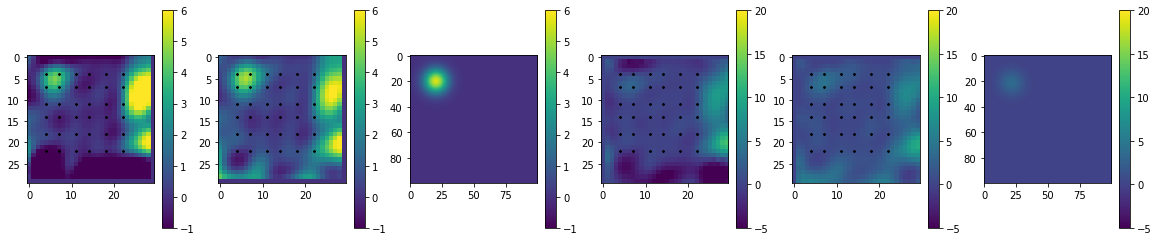

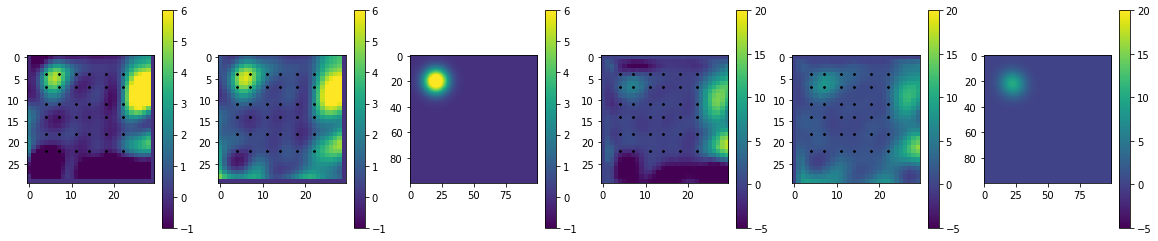

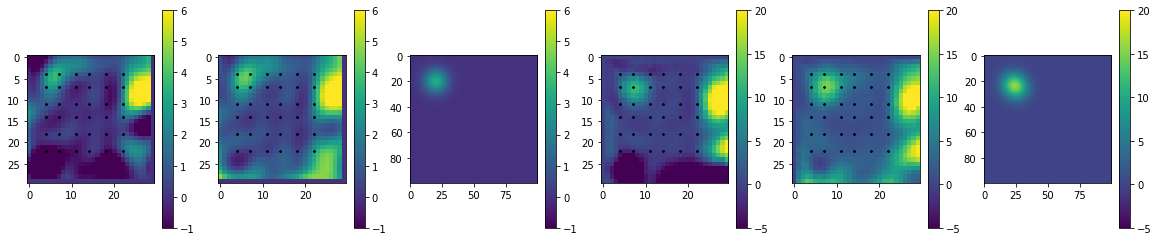

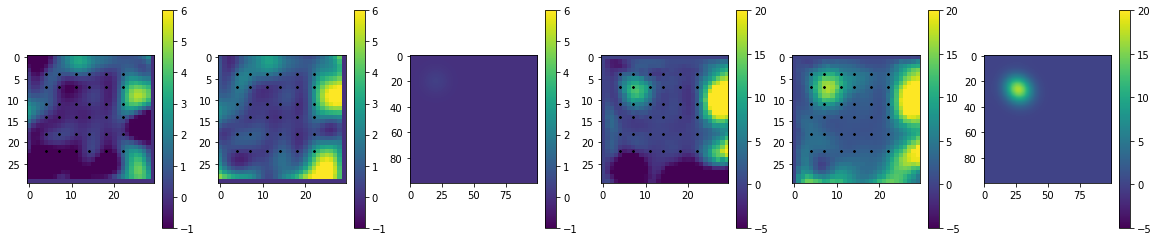

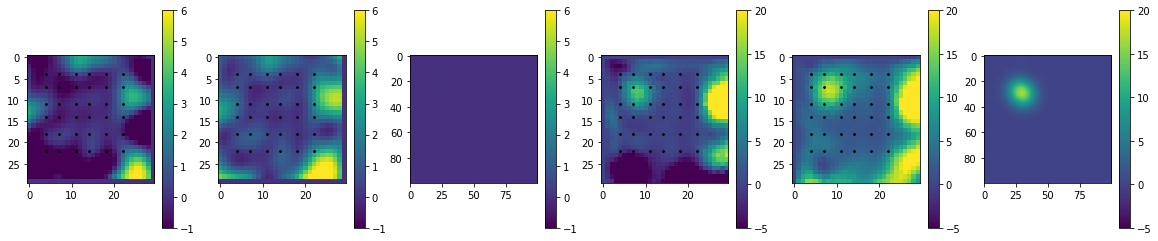

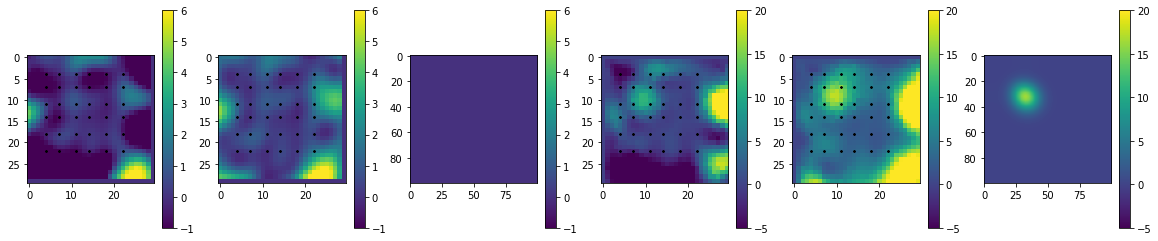

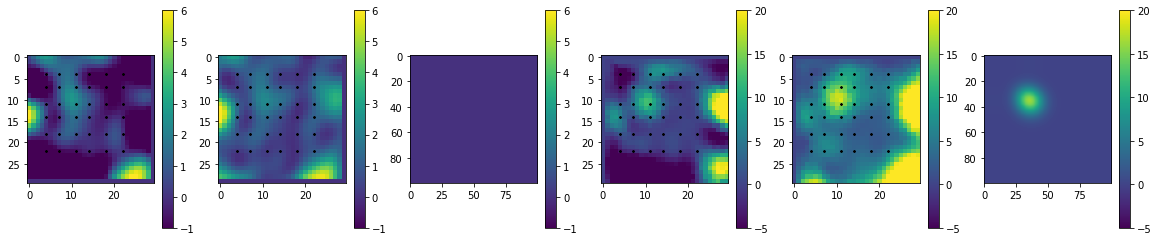

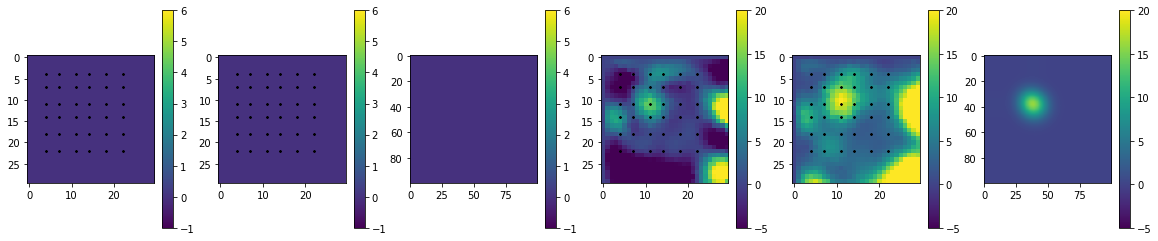

In [13]:
slice_coord=6
gridX = mInfer.getGridCoord(X[:,1:])
plot1d = False
firstrow = True
source_lims = [-1,6]
conc_lims = [-5,20]

for tsamp in np.unique(mInfer.getGridCoord(Xnonneg)[:-1,0]):
    plt.figure(figsize=[20,4])
    plt.subplot(1,6,1)
    if firstrow: plt.title('source')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources[:,tsamp,slice_coord,:].T,'k-',alpha=0.2)
        plt.ylim(source_lims)
        plt.grid()
    else:
        plt.imshow(sourcemean[tsamp,:,:])
        plt.colorbar()
        plt.clim(source_lims)
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')

    plt.subplot(1,6,2)
    if firstrow: plt.title('source (nonneg)')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean_nonneg[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources_nonneg[:,tsamp,slice_coord,:].T,'k-',alpha=0.2)
        plt.vlines(Xnonneg[:,2],0,-1)
        plt.ylim(source_lims)
        plt.grid()
    else:
        plt.imshow(sourcemean_nonneg[tsamp,:,:])
        plt.colorbar()
        plt.clim(source_lims)
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    
    plt.subplot(1,6,3)
    if firstrow: plt.title('realsource')
    if plot1d:    
        plt.plot(sourceGT[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),int(slice_coord*(m.resolution[1]/mInfer.resolution[1])),:])
        plt.grid()
        plt.ylim(source_lims)
    else:
        plt.imshow(sourceGT[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),:,:])   
        plt.clim(source_lims)
        plt.colorbar()    

    plt.subplot(1,6,4)
    if firstrow: plt.title('conc')
    if plot1d:    
        plt.plot(concmean[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.plot(conc[:,tsamp//scaleby[0],slice_coord//scaleby[1],:].T,'k-',alpha=0.2)
        plt.grid()
        plt.ylim(conc_lims)
        plt.vlines(gridX[:,2],0,1,color='green')
    else:
        plt.imshow(concmean[tsamp//scaleby[0],:,:])
        plt.clim(conc_lims)
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')

    plt.subplot(1,6,5)
    if firstrow: plt.title('conc (nonneg)')
    if plot1d:    
        plt.plot(concmean_nonneg[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.plot(conc_nonneg[:,tsamp//scaleby[0],slice_coord//scaleby[1],:].T,'k-',alpha=0.2)
        plt.grid()
        plt.ylim(conc_lims)
        plt.vlines(gridX[:,2],0,1,color='green')
    else:
        plt.imshow(concmean_nonneg[tsamp//scaleby[0],:,:])        
        plt.clim(conc_lims)
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')
    
    plt.subplot(1,6,6)
    if firstrow: plt.title('realconc')
    if plot1d:    
        plt.plot(concTrain[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),int(slice_coord*(m.resolution[1]/mInfer.resolution[1])),:])
        plt.grid()
        plt.ylim(conc_lims)   
    else:
        plt.imshow(concTrain[int(tsamp*(m.resolution[0]/mInfer.resolution[0])),:,:])   
        plt.clim(conc_lims)
        plt.colorbar()
    firstrow = False

In [14]:
particles = mInfer.genParticlesFromObservations(10)
predicted_obs_mean, predicted_obs_var, predicted_obs = mInfer.computeConcentration(Zs=Zs_nonneg,particles=particles,interpolateSource=False)

Initialising particles...
Particle shape:
(10, 180, 3)
Diffusing particles...


In [15]:
np.mean(np.sum((Y-predicted_obs)**2,1)) #average SSE

2682.827312878335

In [16]:
mInfer.computeSourceFromPhiInterpolated(Zs[0,:], particles).shape

(10, 180)

In [17]:
ds = list(range(particles.ndim-1)); ds.insert(0,particles.ndim-1)                
ds

[2, 0, 1]

In [18]:
sources = np.array([mInfer.computeSourceFromPhi(z, particles.transpose(ds)) for z in Zs])
sources.shape

(5, 10, 180)

In [19]:
keep = particles[...,0]>mInfer.boundary[0][0]

In [20]:
keep.shape

(10, 180)

In [21]:
sources.shape

(5, 10, 180)

In [ ]:
sources[:,keep]

In [ ]:
np.zeros((Nsamps,)+particles.shape[:-1]).shape